# Rio de Janeiro labelled satellite imagery from SpaceNet
# We will use this simple classifier to help tell our story about how NetApp's Data Fabric is a critical part of any MLOps data pipeline

# View the contents of the dataset

# How many images are there?

In [1]:
import os
from os.path import join
import json

In [2]:
images_folder = "data/processedBuildingLabels/3band/"
labels_folder = "data/processedBuildingLabels/vectordata/geojson"

In [3]:
print(len([name for name in os.listdir(images_folder)]), "satellite images")

6940 satellite images


In [4]:
print(len([name for name in os.listdir(labels_folder)]), "geojson labels")

6940 geojson labels


In [5]:
#print([name for name in os.listdir(images_folder)])

In [6]:
#print([name for name in os.listdir(labels_folder)])

In [7]:
geojson = [name for name in os.listdir(labels_folder)]

print(geojson[0])

Geo_AOI_1_RIO_img6180.geojson


In [8]:
geo1 = "data/processedBuildingLabels/vectordata/geojson/Geo_AOI_1_RIO_img5394.geojson"

with open(geo1, 'r') as j:
     contents = json.loads(j.read())

#print(contents)
print(json.dumps(contents, indent=4, sort_keys=True))

{
    "crs": {
        "properties": {
            "name": "urn:ogc:def:crs:OGC:1.3:CRS84"
        },
        "type": "name"
    },
    "features": [
        {
            "geometry": {
                "coordinates": [
                    [
                        [
                            -43.55155559999997,
                            -22.8691751,
                            0.0
                        ],
                        [
                            -43.551554299999964,
                            -22.8692016,
                            0.0
                        ],
                        [
                            -43.55147594674406,
                            -22.869198345204104,
                            0.0
                        ],
                        [
                            -43.55147594674406,
                            -22.869275689623297,
                            0.0
                        ],
                        [
                    

# Read a few of the images into arrays

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

Try reading the first image.

Here is the last image.

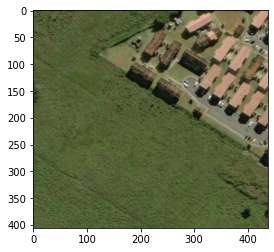

In [10]:
plt.imshow(np.array(Image.open(join(images_folder, os.listdir(images_folder)[-1]))));

# Read all the images into list of arrays

Converting to grayscale as they are opened.

In [11]:
images = [np.array(Image.open(join(images_folder, i)).convert('L')) for i in os.listdir(images_folder)]

In [12]:
print(images[11].shape)

(406, 438)


In [13]:
print(len(images), "images")

6940 images


In [14]:
images[0].shape

(406, 439)

In [15]:
cnt = 0
cnta = 0
cntb = 0
for i in range(len(images)):
 #   print(images[i].shape)
    if images[i].shape == (406,439):
        cnt += 1
    if images[i].shape == (406,438):
        cnta += 1
    if images[i].shape == (407, 439):
        cntb += 1
print('shape: (406, 439) count ',cnt)
print('shape: (406, 438) count ',cnta)
print('shape: (407, 439) count ',cntb)    

shape: (406, 439) count  3372
shape: (406, 438) count  3096
shape: (407, 439) count  472


# Resize some of the images so that they are all the same size

Some images have shape of (406, 438), others have shape of (406, 439).

Change the (406, 439)'s to (406, 438).

In [16]:
from tifffile import imread, imwrite
from skimage.transform import resize


In [17]:
for i in range(len(images)):
    if images[i].shape[1] == 439:    
        images[i] = np.delete(images[i], 439-1, axis=1)

Change the (407, 438)'s to (406, 438)'s.

In [18]:
for i in range(len(images)):
    if images[i].shape[0] == 407:
        images[i] = np.delete(images[i], 407-1, axis=0)

# Downsample the images so they are smaller.

In [19]:
from skimage.transform import downscale_local_mean

4x downsampling.

In [20]:
downscaled_images = []
for i in range(len(images)):
    downscaled_images.append(downscale_local_mean(images[i], (4,4)))

In [21]:
print(images[0])

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [36 59 72 ...  0  0  0]
 [48 64 64 ...  0  0  0]
 [48 47 46 ...  0  0  0]]


In [22]:
downscaled_images[0].shape

(102, 110)

Original image:

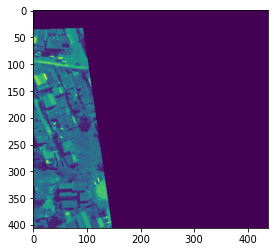

In [23]:
plt.imshow(images[0]);

Downscaled image:

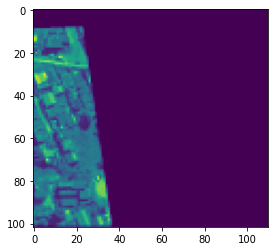

In [24]:
plt.imshow(downscaled_images[0]);

# Convert this list of downscaled arrays into a 3D array

In [25]:
shape = list(downscaled_images[0].shape)
shape[:0] = [len(downscaled_images)]
array_of_images = np.concatenate(downscaled_images).reshape(shape)

In [26]:
array_of_images.shape

(6940, 102, 110)

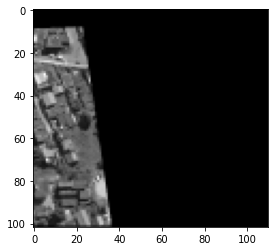

In [27]:
plt.imshow(array_of_images[0], cmap="gray");

# Parse the geojson labels for 1 = building, 0 = no building

In [28]:
import json

Read in all the geojsons.

In [29]:
labels = [json.load(open(join(labels_folder, i))) for i in os.listdir(labels_folder)]

# Create an array containing 1 = buildings, 0 = no buildings

In [30]:
def parse_labels(labels):
    
    results = []
    
    for label in labels:
        
        features = label['features']
        
        # If no features at all, append 0
        if len(features) == 0:
            results.append(0)
            
        # Otherwise, look for building property
        else:
            buildings_in_this_label = []
            for feature in features:
                properties = feature['properties']
                if 'building' in properties.keys():
                    if properties['building'] == 'yes':
                        buildings_in_this_label.append(1)
                    else:
                        buildings_in_this_label.append(0)
                else:
                    buildings_in_this_label.append(0)
            
            # If there is at least one building in this label, append 1
            if sum(buildings_in_this_label) > 0:
                results.append(1)
                
            # Otherwise append 0
            else:
                results.append(0)
                        
    array = np.array(results)
    return array

In [31]:
buildings_no_buildings = parse_labels(labels)

In [32]:
print(buildings_no_buildings.sum(), "of the", buildings_no_buildings.shape[0], "images contain buildings")

4302 of the 6940 images contain buildings


# Frame this as a machine learning problem

In [33]:
X = array_of_images
y = buildings_no_buildings

In [34]:
X.shape

(6940, 102, 110)

In [35]:
y.shape

(6940,)

# Split data into training and testing data

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [38]:
X_train.shape

(5205, 102, 110)

In [39]:
y_train.shape

(5205,)

In [40]:
X_test.shape

(1735, 102, 110)

In [41]:
y_test.shape

(1735,)

# Convolutional Neural Network

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
#K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')


In [43]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# reshape to be [samples][bands][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, X_train[0].shape[0], X_train[0].shape[1]).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, X_test[0].shape[0], X_test[0].shape[1]).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# convert label arrays to categorical
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [44]:
print(y_test.shape[1])
print(X_train.shape[2])
print(X_train.shape[3])

2
102
110


In [45]:
print(type(X_train))

<class 'numpy.ndarray'>


In [46]:
# define the model
def cnn():
    model = Sequential()
    
    model.add(Conv2D(50, (5, 5), input_shape=(1, X_train.shape[2], X_train.shape[3]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
   
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
   # model.add(Dense(num_classes, activation='softmax'))
    model.add(Dense(num_classes, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
    
    return model

In [47]:
# simple early stopping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(
    monitor='acc', 
    patience=8, 
    min_delta=0.001, 
    mode='auto'
)

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='auto', verbose=2, save_best_only=True)

In [48]:
%%time
# build the model
model = cnn()
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=32)
# Final evaluation of the model
scores,acc = model.evaluate(X_test, y_test, verbose=0)
# print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/1000
163/163 [==============================] - 7s 45ms/step - loss: 0.6729 - acc: 0.6171 - val_loss: 0.6681 - val_acc: 0.6265loss: 0.6715 - ac
Epoch 2/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.6697 - acc: 0.6177 - val_loss: 0.6621 - val_acc: 0.6265 3s - loss: 0 - ETA: 1s - loss: 0.6673 - acc: 0.62 - ETA: 1s 
Epoch 3/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.6681 - acc: 0.6177 - val_loss: 0.6679 - val_acc: 0.6265
Epoch 4/1000
163/163 [==============================] - 6s 37ms/step - loss: 0.6678 - acc: 0.6177 - val_loss: 0.6613 - val_acc: 0.6265
Epoch 5/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.6688 - acc: 0.6177 - val_loss: 0.6624 - val_acc: 0.62653s - los - E
Epoch 6/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.6674 - acc: 0.6177 - val_loss: 0.6622 - val_acc: 0.6265
Epoch 7/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.6667 - acc: 0.6177 - 

163/163 [==============================] - 6s 38ms/step - loss: 0.2650 - acc: 0.8853 - val_loss: 1.2013 - val_acc: 0.5712- ETA: 2s - loss: 0.262 - ETA: 1s - loss: 0.263 - ETA: 0s - loss: 0.2657 - acc: 0.
Epoch 61/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.2609 - acc: 0.8847 - val_loss: 1.2261 - val_acc: 0.5522
Epoch 62/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.2639 - acc: 0.8863 - val_loss: 1.2559 - val_acc: 0.56890.886
Epoch 63/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.2610 - acc: 0.8903 - val_loss: 1.2716 - val_acc: 0.5418
Epoch 64/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.2526 - acc: 0.8951 - val_loss: 1.2347 - val_acc: 0.5568
Epoch 65/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.2552 - acc: 0.8903 - val_loss: 1.3103 - val_acc: 0.5654
Epoch 66/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.2497 - acc: 0.9003 - val_loss: 

163/163 [==============================] - 6s 38ms/step - loss: 0.1934 - acc: 0.9230 - val_loss: 1.4449 - val_acc: 0.5677
Epoch 120/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.2021 - acc: 0.9203 - val_loss: 1.3854 - val_acc: 0.5602
Epoch 121/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1906 - acc: 0.9270 - val_loss: 1.4738 - val_acc: 0.5648
Epoch 122/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1917 - acc: 0.9245 - val_loss: 1.5455 - val_acc: 0.5781
Epoch 123/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.2155 - acc: 0.9183 - val_loss: 1.1338 - val_acc: 0.5671
Epoch 124/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.2060 - acc: 0.9251 - val_loss: 1.4616 - val_acc: 0.5758
Epoch 125/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1988 - acc: 0.9249 - val_loss: 1.4290 - val_acc: 0.5689
Epoch 126/1000
163/163 [==============================] 

163/163 [==============================] - 6s 38ms/step - loss: 0.1877 - acc: 0.9301 - val_loss: 1.2846 - val_acc: 0.5562
Epoch 179/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1862 - acc: 0.9247 - val_loss: 1.2540 - val_acc: 0.5695
Epoch 180/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1717 - acc: 0.9306 - val_loss: 1.4337 - val_acc: 0.5712
Epoch 181/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1909 - acc: 0.9295 - val_loss: 1.2608 - val_acc: 0.5666
Epoch 182/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1778 - acc: 0.9301 - val_loss: 1.3179 - val_acc: 0.5631
Epoch 183/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1788 - acc: 0.9305 - val_loss: 1.2315 - val_acc: 0.5712
Epoch 184/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1905 - acc: 0.9256 - val_loss: 1.3754 - val_acc: 0.5695
Epoch 185/1000
163/163 [==============================] 

163/163 [==============================] - 6s 39ms/step - loss: 0.1541 - acc: 0.9408 - val_loss: 1.4399 - val_acc: 0.6017
Epoch 238/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1770 - acc: 0.9399 - val_loss: 1.3622 - val_acc: 0.5890
Epoch 239/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1663 - acc: 0.9356 - val_loss: 1.2451 - val_acc: 0.5723
Epoch 240/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1582 - acc: 0.9385 - val_loss: 1.3973 - val_acc: 0.5735
Epoch 241/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1589 - acc: 0.9395 - val_loss: 1.1539 - val_acc: 0.5706
Epoch 242/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1621 - acc: 0.9406 - val_loss: 1.3353 - val_acc: 0.5666
Epoch 243/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1724 - acc: 0.9337 - val_loss: 1.5716 - val_acc: 0.5833
Epoch 244/1000
163/163 [==============================] 

163/163 [==============================] - 6s 39ms/step - loss: 0.1462 - acc: 0.9485 - val_loss: 1.3096 - val_acc: 0.5654
Epoch 297/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1521 - acc: 0.9445 - val_loss: 1.3617 - val_acc: 0.5758
Epoch 298/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1752 - acc: 0.9358 - val_loss: 1.3823 - val_acc: 0.5931
Epoch 299/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1494 - acc: 0.9477 - val_loss: 1.4682 - val_acc: 0.5793
Epoch 300/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1515 - acc: 0.9422 - val_loss: 1.4987 - val_acc: 0.5677
Epoch 301/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1503 - acc: 0.9445 - val_loss: 1.4350 - val_acc: 0.5412
Epoch 302/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1526 - acc: 0.9414 - val_loss: 1.4139 - val_acc: 0.5885
Epoch 303/1000
163/163 [==============================] 

Epoch 356/1000
163/163 [==============================] - 6s 35ms/step - loss: 0.1560 - acc: 0.9454 - val_loss: 1.3769 - val_acc: 0.5735
Epoch 357/1000
163/163 [==============================] - 6s 35ms/step - loss: 0.1367 - acc: 0.9481 - val_loss: 1.4565 - val_acc: 0.5637
Epoch 358/1000
163/163 [==============================] - 6s 35ms/step - loss: 0.1418 - acc: 0.9508 - val_loss: 1.4264 - val_acc: 0.5775
Epoch 359/1000
163/163 [==============================] - 6s 35ms/step - loss: 0.1429 - acc: 0.9460 - val_loss: 1.3731 - val_acc: 0.5781
Epoch 360/1000
163/163 [==============================] - 6s 35ms/step - loss: 0.1506 - acc: 0.9437 - val_loss: 1.3437 - val_acc: 0.5908
Epoch 361/1000
163/163 [==============================] - 6s 35ms/step - loss: 0.1430 - acc: 0.9464 - val_loss: 1.4650 - val_acc: 0.5931
Epoch 362/1000
163/163 [==============================] - 6s 35ms/step - loss: 0.1488 - acc: 0.9491 - val_loss: 1.3624 - val_acc: 0.5873
Epoch 363/1000
163/163 [=================

163/163 [==============================] - 6s 39ms/step - loss: 0.1357 - acc: 0.9520 - val_loss: 1.3609 - val_acc: 0.5914
Epoch 416/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1495 - acc: 0.9483 - val_loss: 1.3290 - val_acc: 0.5931
Epoch 417/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1446 - acc: 0.9512 - val_loss: 1.4086 - val_acc: 0.5677
Epoch 418/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1554 - acc: 0.9439 - val_loss: 1.2539 - val_acc: 0.5689
Epoch 419/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1365 - acc: 0.9514 - val_loss: 1.4473 - val_acc: 0.5804
Epoch 420/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1607 - acc: 0.9414 - val_loss: 1.5099 - val_acc: 0.5775
Epoch 421/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1468 - acc: 0.9500 - val_loss: 1.3001 - val_acc: 0.5896: 0.
Epoch 422/1000
163/163 [============================

163/163 [==============================] - 6s 38ms/step - loss: 0.1536 - acc: 0.9495 - val_loss: 1.3558 - val_acc: 0.5908
Epoch 471/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1404 - acc: 0.9500 - val_loss: 1.2364 - val_acc: 0.5683
Epoch 472/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1364 - acc: 0.9506 - val_loss: 1.2911 - val_acc: 0.5827
Epoch 473/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1426 - acc: 0.9527 - val_loss: 1.3937 - val_acc: 0.5821
Epoch 474/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1279 - acc: 0.9556 - val_loss: 1.3095 - val_acc: 0.6006
Epoch 475/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1451 - acc: 0.9495 - val_loss: 1.4504 - val_acc: 0.5942
Epoch 476/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1416 - acc: 0.9497 - val_loss: 1.4609 - val_acc: 0.5954
Epoch 477/1000
163/163 [==============================] 

163/163 [==============================] - 6s 38ms/step - loss: 0.1439 - acc: 0.9577 - val_loss: 1.4932 - val_acc: 0.5775
Epoch 527/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1167 - acc: 0.9595 - val_loss: 1.4631 - val_acc: 0.5908: 0
Epoch 528/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1348 - acc: 0.9524 - val_loss: 1.3933 - val_acc: 0.5729
Epoch 529/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1527 - acc: 0.9520 - val_loss: 1.2340 - val_acc: 0.5965
Epoch 530/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1259 - acc: 0.9545 - val_loss: 1.3542 - val_acc: 0.5804
Epoch 531/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1262 - acc: 0.9556 - val_loss: 1.4326 - val_acc: 0.5729
Epoch 532/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1228 - acc: 0.9547 - val_loss: 1.4853 - val_acc: 0.6127
Epoch 533/1000
163/163 [=============================

163/163 [==============================] - 6s 38ms/step - loss: 0.1319 - acc: 0.9545 - val_loss: 1.4395 - val_acc: 0.5890
Epoch 583/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1260 - acc: 0.9600 - val_loss: 1.5185 - val_acc: 0.5412
Epoch 584/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1398 - acc: 0.9514 - val_loss: 1.3254 - val_acc: 0.5775
Epoch 585/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1213 - acc: 0.9581 - val_loss: 1.7415 - val_acc: 0.5977
Epoch 586/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1383 - acc: 0.9556 - val_loss: 1.4368 - val_acc: 0.5810
Epoch 587/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1300 - acc: 0.9562 - val_loss: 1.4485 - val_acc: 0.5873
Epoch 588/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1298 - acc: 0.9537 - val_loss: 1.4597 - val_acc: 0.5844
Epoch 589/1000
163/163 [==============================] 

163/163 [==============================] - 6s 38ms/step - loss: 0.1234 - acc: 0.9560 - val_loss: 1.5403 - val_acc: 0.5833
Epoch 640/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1101 - acc: 0.9612 - val_loss: 1.5485 - val_acc: 0.5890
Epoch 641/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1145 - acc: 0.9618 - val_loss: 1.6206 - val_acc: 0.5643
Epoch 642/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1066 - acc: 0.9656 - val_loss: 1.4540 - val_acc: 0.5689
Epoch 643/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1273 - acc: 0.9612 - val_loss: 1.3570 - val_acc: 0.5914
Epoch 644/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1018 - acc: 0.9641 - val_loss: 1.8715 - val_acc: 0.5810
Epoch 645/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1258 - acc: 0.9572 - val_loss: 1.3803 - val_acc: 0.5741
Epoch 646/1000
163/163 [==============================] 

163/163 [==============================] - 6s 38ms/step - loss: 0.1248 - acc: 0.9581 - val_loss: 1.4137 - val_acc: 0.5850
Epoch 697/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1386 - acc: 0.9531 - val_loss: 1.2429 - val_acc: 0.5775
Epoch 698/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1282 - acc: 0.9577 - val_loss: 1.5464 - val_acc: 0.5850
Epoch 699/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1219 - acc: 0.9597 - val_loss: 1.3178 - val_acc: 0.5781
Epoch 700/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1255 - acc: 0.9598 - val_loss: 1.3844 - val_acc: 0.5833
Epoch 701/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1190 - acc: 0.9622 - val_loss: 1.5541 - val_acc: 0.5833
Epoch 702/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1206 - acc: 0.9614 - val_loss: 1.4419 - val_acc: 0.5937
Epoch 703/1000
163/163 [==============================] 

163/163 [==============================] - 6s 38ms/step - loss: 0.1145 - acc: 0.9637 - val_loss: 1.3410 - val_acc: 0.5867
Epoch 754/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1135 - acc: 0.9581 - val_loss: 1.6793 - val_acc: 0.5960
Epoch 755/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1163 - acc: 0.9583 - val_loss: 1.7514 - val_acc: 0.5671
Epoch 756/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1259 - acc: 0.9600 - val_loss: 1.4611 - val_acc: 0.5579
Epoch 757/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1163 - acc: 0.9620 - val_loss: 1.5119 - val_acc: 0.5758
Epoch 758/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.1384 - acc: 0.9587 - val_loss: 1.3534 - val_acc: 0.5827A: 1s - loss: 
Epoch 759/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1041 - acc: 0.9656 - val_loss: 1.4624 - val_acc: 0.5856TA: 1s - loss: 0.10
Epoch 760/1000
163/163 

163/163 [==============================] - 6s 38ms/step - loss: 0.1238 - acc: 0.9577 - val_loss: 1.5361 - val_acc: 0.5741
Epoch 812/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1020 - acc: 0.9631 - val_loss: 1.5940 - val_acc: 0.5833
Epoch 813/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1130 - acc: 0.9637 - val_loss: 1.4146 - val_acc: 0.5746
Epoch 814/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1143 - acc: 0.9622 - val_loss: 1.5545 - val_acc: 0.5914
Epoch 815/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1328 - acc: 0.9581 - val_loss: 1.3798 - val_acc: 0.5850
Epoch 816/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1195 - acc: 0.9618 - val_loss: 1.6628 - val_acc: 0.5781
Epoch 817/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1255 - acc: 0.9577 - val_loss: 1.5147 - val_acc: 0.5758
Epoch 818/1000
163/163 [==============================] 

163/163 [==============================] - 6s 38ms/step - loss: 0.1148 - acc: 0.9610 - val_loss: 1.4884 - val_acc: 0.6006
Epoch 869/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1228 - acc: 0.9608 - val_loss: 1.4388 - val_acc: 0.5712
Epoch 870/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1094 - acc: 0.9622 - val_loss: 1.5346 - val_acc: 0.5695
Epoch 871/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1187 - acc: 0.9625 - val_loss: 1.4500 - val_acc: 0.5977
Epoch 872/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1203 - acc: 0.9591 - val_loss: 1.5214 - val_acc: 0.5873
Epoch 873/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1171 - acc: 0.9583 - val_loss: 1.4434 - val_acc: 0.5873118
Epoch 874/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1039 - acc: 0.9660 - val_loss: 1.4352 - val_acc: 0.5821
Epoch 875/1000
163/163 [=============================

163/163 [==============================] - 6s 38ms/step - loss: 0.0981 - acc: 0.9633 - val_loss: 1.5737 - val_acc: 0.5723
Epoch 925/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1054 - acc: 0.9610 - val_loss: 1.6554 - val_acc: 0.5827
Epoch 926/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.0935 - acc: 0.9710 - val_loss: 1.6432 - val_acc: 0.5793
Epoch 927/1000
163/163 [==============================] - 6s 39ms/step - loss: 0.0925 - acc: 0.9695 - val_loss: 1.5706 - val_acc: 0.5625
Epoch 928/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1194 - acc: 0.9608 - val_loss: 1.4841 - val_acc: 0.58331197 - ac - ETA: 0s - loss: 0.1225 -
Epoch 929/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1009 - acc: 0.9662 - val_loss: 1.5470 - val_acc: 0.5718
Epoch 930/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1091 - acc: 0.9616 - val_loss: 1.3797 - val_acc: 0.5689s - loss: - ETA: 2s -

163/163 [==============================] - 6s 38ms/step - loss: 0.1188 - acc: 0.9643 - val_loss: 1.5275 - val_acc: 0.5902
Epoch 982/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1008 - acc: 0.9660 - val_loss: 1.5738 - val_acc: 0.5850
Epoch 983/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1147 - acc: 0.9612 - val_loss: 1.4150 - val_acc: 0.6017
Epoch 984/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1062 - acc: 0.9646 - val_loss: 1.4540 - val_acc: 0.5793
Epoch 985/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.0936 - acc: 0.9679 - val_loss: 1.8869 - val_acc: 0.6161 0.0947 - acc: - ETA: 0s - loss: 0.0943 - acc: 0.9
Epoch 986/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1082 - acc: 0.9656 - val_loss: 1.6371 - val_acc: 0.5677
Epoch 987/1000
163/163 [==============================] - 6s 38ms/step - loss: 0.1148 - acc: 0.9675 - val_loss: 1.3537 - val_acc: 0.5839
Epoch 

In [49]:
print('Test score:', scores)
print('Test accuracy:', acc)

Test score: 1.5889219045639038
Test accuracy: 0.579250693321228


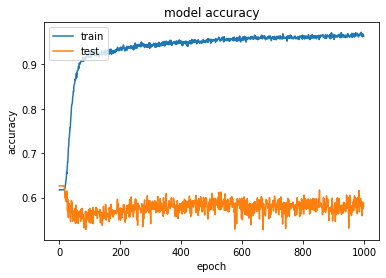

In [50]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

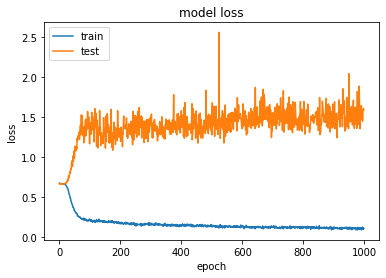

In [51]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
X_train[0]

array([[[0.32671568, 0.35661766, 0.38431373, ..., 0.475     ,
         0.6215686 , 0.3142157 ],
        [0.26715687, 0.34436274, 0.35882354, ..., 0.6009804 ,
         0.61960787, 0.30857843],
        [0.32990196, 0.3629902 , 0.35637254, ..., 0.6213235 ,
         0.6139706 , 0.30318627],
        ...,
        [0.10098039, 0.09264706, 0.10294118, ..., 0.45171568,
         0.45661765, 0.21936275],
        [0.14142157, 0.12769608, 0.09460784, ..., 0.36911765,
         0.4379902 , 0.22352941],
        [0.28529412, 0.19877452, 0.03406863, ..., 0.05367647,
         0.17156863, 0.11127451]]], dtype=float32)

In [53]:
X_train[0].shape

(1, 102, 110)

In [54]:
#y_pred = model.predict_classes(X_test, batch_size=32)
y_pred = np.argmax(model.predict(X_test), axis=-1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [56]:
#y_test

In [57]:
#y_pred

In [58]:
import sys
np.set_printoptions(threshold=sys.maxsize)

Confusion matrix.

In [59]:
import cv2
import numpy as np

In [60]:
from sklearn.metrics import confusion_matrix
result=confusion_matrix(y_test, y_pred)
print(result)

[[171 477]
 [253 834]]


# View the first 10 predictions

In [61]:
print(len(y))

6940


In [62]:
def view_prediction_vs_actual(i, y_pred, X=X, y=y):
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.25, random_state=42)
    
    f, ax = plt.subplots()
    plt.imshow(X_test_orig[i], cmap='gray')
    
    prediction = ['no_building', 'building'][y_pred[i]]
    actual = ['no_building', 'building'][y_test_orig[i]]
    
    if prediction == actual:
        ax.annotate("CORRECT", (5,90), color='white', weight='bold',fontsize=16, bbox={'facecolor':'green', 'alpha':0.9, 'pad':5})
    else:
        ax.annotate("INCORRECT", (5,90), color='white', weight='bold',fontsize=16, bbox={'facecolor':'red', 'alpha':0.9, 'pad':5})
    
    ax.annotate("prediction:  " + prediction, (5, 10), color='white', weight='bold',fontsize=16)
    ax.annotate("actual:  " + actual, (5, 20), color='white', weight='bold',fontsize=16)
    
    return f

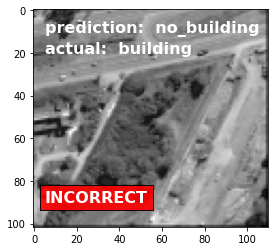

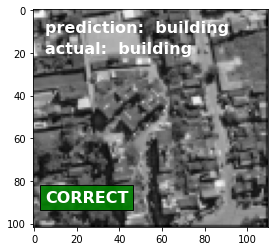

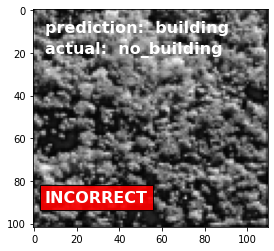

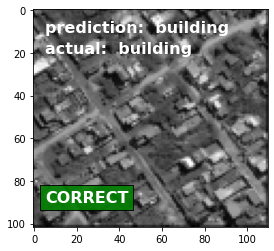

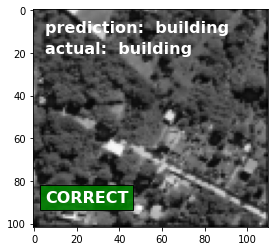

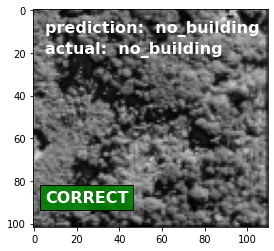

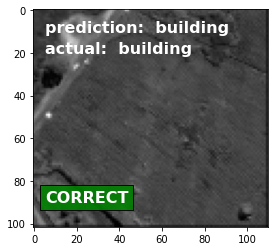

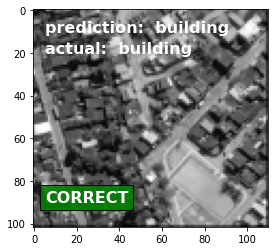

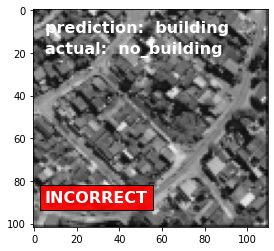

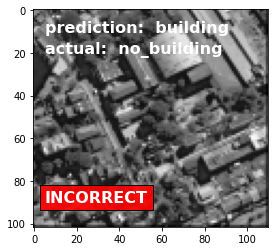

In [63]:
# appears some of the test data is mislabeled
for i in range(10):
    view_prediction_vs_actual(i, y_pred)

In [64]:
model.save("data/model/demo_model_4")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: data/model/demo_model_4/assets
